In [1]:
# Load all packages
import torch
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
     
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib
from torch import nn
import neptune.new as neptune
import random

In [ ]:
# Get the APi key, from outside the git folder.
file = open("../API-key.txt", "r")
key = file.readlines()

run = neptune.init(
    project="Facemask-project/Facemask",
    api_token=key[0])

# Choose the device:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
run['namespace/Run_name'] = "No_flat_layer_14"
run['sys/tags'].add(['size_125', "no_argument", "no_flat_Layer"])

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#Create the data loader. This data
class DataLoader():
    def __init__(self, img_dir, img_dir2, transform = None, target_transform=None, transforms = None,
                 random_perspective = None, flip = None):
        self.img_dir = img_dir
        self.img_dir2 = img_dir2
        self.transform = transform
        self.transforms = transforms
        self.fileNames = os.listdir(img_dir)
        self.random_perspective = random_perspective
    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        label = self.fileNames[idx].rsplit("t-mask-", 1 )[1]
        img_path = os.path.join(self.img_dir, self.fileNames[idx])
        img_path2 = os.path.join(self.img_dir2, label)
        image = read_image(img_path)
        target_image = read_image(img_path2)
        image = image.clone().detach().float()
        target_image = target_image.clone().detach().float()
        if self.transforms:
            image = self.transforms(image)
            target_image = self.transforms(target_image)
        if self.random_perspective:
            if random.uniform(0,1) > 0.5:
                scale = random.uniform(0,0.3)
                startpoints, endpoints = transforms.RandomPerspective().get_params(50,50, distortion_scale=scale)
                image = torchvision.transforms.functional.perspective(image, startpoints, endpoints)
                target_image  = torchvision.transforms.functional.perspective(target_image, startpoints, endpoints)
        
        return image, target_image

In [3]:
#Choose batch_size:
batch_size = 25

#create transformer with mean = 0 and std = 1.
transformer=transforms.Compose([ transforms.Normalize((0, 0, 0), (1, 1, 1))])

#Create the dataset with the dataloader:
dataset = DataLoader("Data_small/125_with_mask_train", "Data_small/125_without_mask_train",
                     transform = transformer,
                    random_perspective = None) 

# split the dataset into test and train set.
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
test_train_split = [test_size, train_size]
testdata, traindata = torch.utils.data.random_split(dataset = dataset, lengths = test_train_split)

# Set up dataloader and the test
trainloader = torch.utils.data.DataLoader(traindata, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0,
                                          pin_memory=True)
testloader = torch.utils.data.DataLoader(testdata, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=0,
                                          pin_memory=True)
dataiter = iter(trainloader)


In [4]:
# with auto encoder:

import torch.nn.functional as F
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
           
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(7200,5000)
        self.linear2 = nn.Linear(5000,4800)
        self.linear3 = nn.Linear(4800,4500)
  

        #Encoder
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv11 = nn.Conv2d(8, 16, 3, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 50, 7, padding=3)
        self.conv4 = nn.Conv2d(50, 60, 5, padding=2)
        self.conv5 = nn.Conv2d(60, 40, 3, padding=1)
        self.conv6 = nn.Conv2d(40, 20, 3, padding=1)
       
        self.pool = nn.MaxPool2d(2, 2)
        self.unflatten = nn.Unflatten(dim =1, unflattened_size = (20,15,15))
        
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(20, 32, 2, stride=2, output_padding = 1)
        self.t_conv2 = nn.ConvTranspose2d(32, 64, 2, stride=2)
        self.decode_conv1 =  nn.Conv2d(64, 128, 5, padding=2)
        self.t_conv3 = nn.ConvTranspose2d(128, 64 , 2, stride=2)
        self.t_conv4 = nn.ConvTranspose2d(64, 32, 2, stride=1)
        self.decode_conv2 = nn.Conv2d(32, 16, 5, padding=2)
        self.decode_conv3 = nn.Conv2d(16, 3, 3, padding=1)
        

    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = F.relu(self.conv6(x))
        return x
    
    def flatlayer(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = self.unflatten(x)
        return x
    
    def decode(self, x):
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.decode_conv1(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        x = F.relu(self.decode_conv2(x))
        x = F.relu(self.decode_conv3(x))
        return x
        
    def forward(self, x):
        x = self.encode(x)
        #x = self.flatlayer(x)
        x = self.decode(x)      
        return x


#Instantiate the model
model = ConvAutoencoder()

#Send the model to the device
model.to(device)
# check the model output is the correct size
model(dataiter.next()[0].to(device)).size()

C:\Users\nbjer\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([25, 3, 125, 125])

In [5]:
learning_rate = 0.0001
#Loss function
criterion = torch.nn.MSELoss()

#Optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
def update_params():
    run["parameters"] = {"lr": learning_rate,
                         "optim": str(optimizer).split(" ")[0],
                         "loss_function" : str(criterion),
                         "Batch_size": batch_size,
                         "image_size": 125
                        }
update_params()

In [12]:
#Epochs
def train(model, n_epochs = 10, criterion = criterion, optimizer = optimizer, trainloader = trainloader):
    model.train()
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        #Training
        for data in trainloader:
            mask_image, image = data
            mask_image , image = mask_image.to(device), image.to(device)
            image = image.clone().detach().float()
            mask_image = mask_image.clone().detach().float()
            optimizer.zero_grad()
            outputs = model(mask_image)
            loss = criterion(outputs, image)
            loss.backward()
            optimizer.step()
        if (epoch % 1 == 0):
            train_loss += loss.item()
            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
            run["train/loss"].log(train_loss)
        if (epoch % 50 ==0):
            checpoint_name = "checkpoint" + str(epoch)
            save_checkpoint(model, checpoint_name)

In [20]:
model.train()
train(model, n_epochs = 40)


Epoch: 1 	Training Loss: 1299.314819
Epoch: 2 	Training Loss: 1358.675293
Epoch: 3 	Training Loss: 1166.563354
Epoch: 4 	Training Loss: 1162.773315
Epoch: 5 	Training Loss: 1250.303589
Epoch: 6 	Training Loss: 1213.229736
Epoch: 7 	Training Loss: 1277.083374
Epoch: 8 	Training Loss: 1424.376343
Epoch: 9 	Training Loss: 1193.001221
Epoch: 10 	Training Loss: 1318.603516
Epoch: 11 	Training Loss: 1413.476807
Epoch: 12 	Training Loss: 1290.844971
Epoch: 13 	Training Loss: 1189.323486
Epoch: 14 	Training Loss: 1270.802002
Epoch: 15 	Training Loss: 1149.318115
Epoch: 16 	Training Loss: 1241.654663
Epoch: 17 	Training Loss: 1233.787231
Epoch: 18 	Training Loss: 1124.574829
Epoch: 19 	Training Loss: 1243.419556
Epoch: 20 	Training Loss: 1241.035278
Epoch: 21 	Training Loss: 1186.104614
Epoch: 22 	Training Loss: 1196.864746
Epoch: 23 	Training Loss: 946.538879
Epoch: 24 	Training Loss: 1135.568237
Epoch: 25 	Training Loss: 904.596741
Epoch: 26 	Training Loss: 1020.636719
Epoch: 27 	Training Los

In [7]:
model = torch.load("god_model.pt",map_location=torch.device('cpu'))

In [8]:
def print_image(image, model, correct_image, neptune_upload = False):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(np.transpose(image.numpy(), (1, 2, 0)).astype('uint8'))
    ax2.imshow(np.transpose(correct_image.numpy(), (1, 2, 0)).astype('uint8'))
    image = torch.unsqueeze(image,0)
    image = image.clone().detach().float()
    image = image.to(device)
    output = model(image)
    output = torch.squeeze(output,0)
    if device.type == 'cuda':
        output = torch.Tensor.cpu(output).clone().detach().numpy()
    else:
        output = output.clone().detach().numpy()
        

    ax3.imshow(np.transpose(output, (1, 2, 0)).astype('uint8'))
    if neptune_upload:
        run['Test_figures'].upload(fig)
    plt.show()

In [9]:
dataiter = iter(testloader)

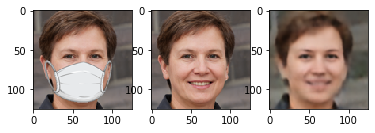

In [11]:
#Test a Model
model.eval()

images, images2 = dataiter.next()
#print_image(images[0], model = model2, correct_image = images2[0])
print_image(images[0], model = model, correct_image = images2[0])

In [29]:
#Save the model as a artifact
def save_checkpoint(model, checkpoint_name):
    checkpoint_name_ext = checkpoint_name + ".pt"
    checkpoints = os.listdir("Checkpoints")
    path = os.path.join("Checkpoints", checkpoint_name_ext)
    try_number = 0
    while (os.path.exists(path)):
        try_number += 1
        checkpoint_name_ext = checkpoint_name + "_" + str(try_number) + ".pt"
        path = os.path.join("Checkpoints", checkpoint_name_ext)
    torch.save(model, path)
    neptune_checkpoint_path = 'model_checkpoints/' + checkpoint_name + "_" + str(try_number)
    run[neptune_checkpoint_path].upload(path)

In [30]:
save_checkpoint(model,"size_125_Large_model_no_flatlayer_60_epochs")

In [31]:
run['sys/tags'].add(["Decent"])

In [32]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 7 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 7 operations (0.00% done). Please wait.


All 7 operations synced, thanks for waiting!


In [12]:
from skimage.metrics import structural_similarity as ssim

In [39]:
def ssim_measure(img1, img2):
    loss = 0
    for i in range(3):
        loss += 1/3*ssim(img1[i], img2[i])
    
    return loss

In [14]:
images, images2 = dataiter.next()

In [16]:
no_mask = torch.squeeze(images2,0).numpy()


In [30]:
output = model(images)

In [36]:
output = output.squeeze(0).detach().numpy()

In [40]:
ssim_measure(output, no_mask)

0.6397804409237948

In [32]:
output.squeeze

tensor([[[[122.6047, 137.5239, 135.9972,  ..., 136.5306, 143.3687, 123.3076],
          [132.6912, 129.0182, 127.7901,  ..., 138.0157, 143.5121, 141.7047],
          [128.3496, 125.7758, 127.4232,  ..., 136.7095, 135.3774, 139.6746],
          ...,
          [120.9047, 122.5775, 114.8635,  ..., 103.9903, 102.2100, 100.2333],
          [121.2808, 120.3977, 113.0540,  ..., 106.5363, 106.1206, 108.1413],
          [110.6031, 120.8428, 113.6612,  ..., 107.3107, 111.6070, 101.4553]],

         [[118.0889, 131.0032, 134.4741,  ..., 129.1161, 125.5269, 117.0557],
          [126.3649, 125.0838, 128.6213,  ..., 133.4928, 135.1476, 132.6604],
          [126.8617, 126.0406, 128.2815,  ..., 131.1884, 130.1684, 129.9839],
          ...,
          [113.8527, 109.1086, 102.6294,  ...,  93.0199,  90.0821,  92.3008],
          [113.9137, 111.3873, 103.8610,  ...,  98.2964,  96.9200,  99.9688],
          [ 99.1123, 109.0527, 101.8774,  ..., 101.8976, 104.9943,  95.0860]],

         [[106.4467, 106.5122,